<a href="https://colab.research.google.com/github/EngAmirEskandari/Source-localization/blob/main/Kernel_is_Dead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import numpy as np
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt



In [2]:
def sbm(n, c, p_intra, p_inter):

    community = np.repeat(list(range(c)), np.ceil(n/c), axis = None)

    community = community[0:n]

    community = np.expand_dims(community,1)

    intra = community == community.T

    inter = np.logical_not(intra)

    random = np.random.random((n,n))

    tri = np.tri(n,k=-1)

    graph = np.zeros((n,n))

    graph[np.logical_and.reduce([tri, intra, random < p_intra],0)] = 1

    graph[np.logical_and.reduce([tri, inter, random < p_inter],0)] = 1
    
    graph += graph.T 

    return graph

In [3]:
S = sbm(n = 50, c = 5 , p_intra = 0.6, p_inter = 0.2)

In [4]:
def normalize_gso(gso):

    eigenvalues, _ = np.linalg.eig(gso)

    return gso / np.max(np.abs(eigenvalues))

In [5]:
S = normalize_gso(S)

In [6]:
def generate_diffusion(gso, n_samples, n_sources):

    n = gso.shape[0]

    z = np.zeros((n_samples, n,5,1))

    for i in range(n_samples):

        sources = np.random.choice(n ,n_sources, replace = False)

        z[i,sources,0,0] = np.random.uniform(0,10)

    mu = np.zeros(n)
    sigma = np.eye(n)* 1e-3

    for t in range(4):

        noise = np.random.multivariate_normal(mu,sigma,n_samples)

        z[:,:,t+1] = gso @ z[:,:,t] + np.expand_dims(noise,-1)
    
    z = z.transpose((0,2,1,3))
    
    return z.squeeze()

In [62]:
z = generate_diffusion(S, 2100, 10)

In [63]:
def data_from_diffusion(z):

    z = np.random.permutation(z)

    y = np.expand_dims(z[:,0,:],1) #Z[0] is our y 

    x = np.zeros(y.shape)

    for i, sample in enumerate(z):
        x[i] = sample[4]
        

    return x.squeeze(), y.squeeze()

In [64]:
x,y = data_from_diffusion(z)

In [65]:
def split_data(x,y,splits=(2000,100)):

    splits = np.cumsum([0]+list(splits))
    splits = (splits * x.shape[0] / splits[-1]).astype(int)

    return ((x[splits[i]:splits[i + 1]], y[splits[i]:splits[i + 1]]) for i in range(len(splits) - 1))

In [26]:
x,y = data_from_diffusion(z)
trainData, testData = split_data(x, y, (2000,100))
xTrain = trainData[0]
yTrain = trainData[1]
xTest = testData[0]
yTest = testData[1]

In [27]:
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)

In [13]:
import torch

def FilterFunction(h, S, x):

    K = h.shape[0] # number of filter taps
    B = x.shape[0] # batch size
    N = x.shape[1] # number of nodes

    x = x.reshape([B, 1, N])
    S = S.reshape([1, N, N])
    z = x

    for k in range(1, K):

        # diffusion step, S^k*x
        x = torch.matmul(x, S)
        xS = x.reshape([B, 1, N]) 

        # concatenate the S^k*x in the tensor z
        z = torch.cat((z, xS), dim=1) 

    # multiply z and h in the concatenation dimension
    y = torch.matmul(z.permute(0, 2, 1).reshape([B, N, K]), h)

    return y

In [14]:
import torch.nn as nn
import math
    
class GraphFilter(nn.Module):
    def __init__(self, gso, k):
        
        # Initialize parent
        super().__init__()
        
        # Save filter hyperparameters
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        
        # Define and initialize learnable weights
        self.weight = nn.Parameter(torch.randn(self.k))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return FilterFunction(self.weight, self.gso, x)

In [15]:
graphFilter = GraphFilter(S, 8).double()



Epoch 1

    (E:  1, B:   1) 


	 Graph Filter: 4.6983 [T] 6.7975 [V]









    (E:  1, B:   6) 


	 Graph Filter: 4.7737 [T] 6.6377 [V]









Epoch 2

    (E:  2, B:   1) 


	 Graph Filter: 5.1666 [T] 6.6379 [V]









    (E:  2, B:   6) 


	 Graph Filter: 4.7620 [T] 6.6369 [V]









Epoch 3

    (E:  3, B:   1) 


	 Graph Filter: 5.0146 [T] 6.6372 [V]









    (E:  3, B:   6) 


	 Graph Filter: 5.2977 [T] 6.6374 [V]









Epoch 4

    (E:  4, B:   1) 


	 Graph Filter: 5.5537 [T] 6.6362 [V]









    (E:  4, B:   6) 


	 Graph Filter: 4.9035 [T] 6.6352 [V]









Epoch 5

    (E:  5, B:   1) 


	 Graph Filter: 5.0366 [T] 6.6346 [V]









    (E:  5, B:   6) 


	 Graph Filter: 5.0443 [T] 6.6338 [V]









Epoch 6

    (E:  6, B:   1) 


	 Graph Filter: 5.2425 [T] 6.6332 [V]









    (E:  6, B:   6) 


	 Graph Filter: 5.1008 [T] 6.6327 [V]









Epoch 7

    (E:  7, B:   1) 


	 Graph Filter: 5.2863 [T] 6.6319 [V]









    (E:  7, B:   6) 


	 G

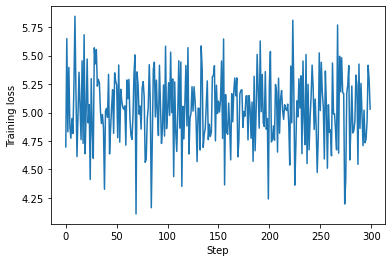

Final evaluation results
 Graph Filter: 4.4271 [Best] 4.4268 [Last]


In [31]:
# -*- coding: utf-8 -*


loss = nn.MSELoss()

nTrain = 2000
nTest = 100



################################
########### TRAINING ###########
################################

validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:]
yValid = yTrain[0:nValid,:]
xTrain = xTrain[nValid:,:]
yTrain = yTrain[nValid:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizer = optim.Adam(graphFilter.parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
lossValid = dict()
# ...and test variables
lossTestBest = dict()
lossTestLast = dict()

bestModel = dict()

lossTrain = []
lossValid = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:]
        yTrainBatch = yTrain[thisBatchIndices,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
       
        # Reset gradients
        graphFilter.zero_grad()

        # Obtain the output of the architectures
        yHatTrainBatch = graphFilter(xTrainBatch)
        print('\n')
        # Compute loss
        lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

        # Compute gradients
        lossValueTrain.backward()

        # Optimize
        optimizer.step()
        
        lossTrain += [lossValueTrain.item()]
        
        # Print:
        if (epoch * nBatches + batch) % validationInterval == 0:
            with torch.no_grad():
                # Obtain the output of the GNN
                yHatValid = graphFilter(xValid)
    
            # Compute loss
            lossValueValid = loss(yHatValid, yValid)
            
            lossValid += [lossValueValid.item()]

            print("\t Graph Filter: %6.4f [T]" % (
                    lossValueTrain) + " %6.4f [V]" % (
                    lossValueValid))
            
            # Saving the best model so far
            if len(lossValid) > 1:
                if lossValueValid <= min(lossValid):
                    bestModel =  copy.deepcopy(graphFilter)
            else:
                bestModel =  copy.deepcopy(graphFilter)
                    
        batch+=1
        
    epoch+=1
    
print("")

################################
############# PLOT #############
################################
 
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

with torch.no_grad():
    yHatTest = graphFilter(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" Graph Filter: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))
 

Neural perceptron

In [32]:
class GraphPerceptron(nn.Module):
    def __init__(self, gso, k, sigma):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.sigma = sigma
        self.weight = nn.Parameter(torch.randn(self.k))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        y = FilterFunction(self.weight, self.gso, x)
        y = self.sigma(y)
        return y    

In [33]:
graphPerceptron = GraphPerceptron(S, 8, nn.ReLU())


Epoch 1

    (E:  1, B:   1) 
	 Graph Perceptron: 5.3684 [T] 4.4517 [V]

    (E:  1, B:   6) 
	 Graph Perceptron: 5.1997 [T] 4.4231 [V]

Epoch 2

    (E:  2, B:   1) 
	 Graph Perceptron: 5.8437 [T] 4.4132 [V]

    (E:  2, B:   6) 
	 Graph Perceptron: 4.8388 [T] 4.4105 [V]

Epoch 3

    (E:  3, B:   1) 
	 Graph Perceptron: 5.1977 [T] 4.4096 [V]

    (E:  3, B:   6) 
	 Graph Perceptron: 5.5810 [T] 4.4089 [V]

Epoch 4

    (E:  4, B:   1) 
	 Graph Perceptron: 6.0357 [T] 4.4074 [V]

    (E:  4, B:   6) 
	 Graph Perceptron: 5.3154 [T] 4.4052 [V]

Epoch 5

    (E:  5, B:   1) 
	 Graph Perceptron: 5.5510 [T] 4.4028 [V]

    (E:  5, B:   6) 
	 Graph Perceptron: 5.3194 [T] 4.4009 [V]

Epoch 6

    (E:  6, B:   1) 
	 Graph Perceptron: 5.4560 [T] 4.3991 [V]

    (E:  6, B:   6) 
	 Graph Perceptron: 5.6308 [T] 4.3970 [V]

Epoch 7

    (E:  7, B:   1) 
	 Graph Perceptron: 5.3343 [T] 4.3948 [V]

    (E:  7, B:   6) 
	 Graph Perceptron: 4.8321 [T] 4.3927 [V]

Epoch 8

    (E:  8, B:   1) 
	 Graph Pe

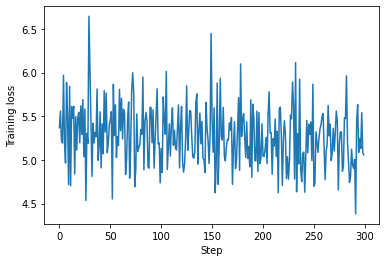

Final evaluation results
 Graph Perceptron: 4.5319 [Best] 4.5296 [Last]


In [34]:
loss = nn.MSELoss()


################################
########### TRAINING ###########
################################

validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:]
yValid = yTrain[0:nValid,:]
xTrain = xTrain[nValid:,:]
yTrain = yTrain[nValid:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizer = optim.Adam(graphPerceptron.parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
lossValid = dict()
# ...and test variables
lossTestBest = dict()
lossTestLast = dict()

bestModel = dict()

lossTrain = []
lossValid = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:]
        yTrainBatch = yTrain[thisBatchIndices,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
       
        # Reset gradients
        graphPerceptron.zero_grad()

        # Obtain the output of the architectures
        yHatTrainBatch = graphPerceptron(xTrainBatch)

        # Compute loss
        lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

        # Compute gradients
        lossValueTrain.backward()

        # Optimize
        optimizer.step()
        
        lossTrain += [lossValueTrain.item()]
        
        # Print:
        if (epoch * nBatches + batch) % validationInterval == 0:
            with torch.no_grad():
                # Obtain the output of the GNN
                yHatValid = graphPerceptron(xValid)
    
            # Compute loss
            lossValueValid = loss(yHatValid, yValid)
            
            lossValid += [lossValueValid.item()]

            print("\t Graph Perceptron: %6.4f [T]" % (
                    lossValueTrain) + " %6.4f [V]" % (
                    lossValueValid))
            
            # Saving the best model so far
            if len(lossValid) > 1:
                if lossValueValid <= min(lossValid):
                    bestModel =  copy.deepcopy(graphPerceptron)
            else:
                bestModel =  copy.deepcopy(graphPerceptron)
                    
        batch+=1
        
    epoch+=1
    
print("")

################################
############# PLOT #############
################################
 
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

with torch.no_grad():
    yHatTest = graphPerceptron(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" Graph Perceptron: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))
 

**Multi Layer Perceptron**

In [39]:
class MLGNN(nn.Module):
    def __init__(self, gso, l, k, sigma):
        super().__init__()
        layers = []
        for layer in range(l):
            layers.append(GraphPerceptron(gso, k[layer], sigma))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y = self.layers(x)
        return y

In [40]:
MLGNN = MLGNN(S, 3, [8, 5, 1], nn.ReLU())


Epoch 1

    (E:  1, B:   1) 
	 MLGNN: 5.8557 [T] 4.7638 [V]

    (E:  1, B:   6) 
	 MLGNN: 6.2235 [T] 4.7638 [V]

Epoch 2

    (E:  2, B:   1) 
	 MLGNN: 6.2581 [T] 4.7638 [V]

    (E:  2, B:   6) 
	 MLGNN: 7.0655 [T] 4.7638 [V]

Epoch 3

    (E:  3, B:   1) 
	 MLGNN: 6.9242 [T] 4.7638 [V]

    (E:  3, B:   6) 
	 MLGNN: 6.3592 [T] 4.7638 [V]

Epoch 4

    (E:  4, B:   1) 
	 MLGNN: 6.5976 [T] 4.7638 [V]

    (E:  4, B:   6) 
	 MLGNN: 6.1011 [T] 4.7638 [V]

Epoch 5

    (E:  5, B:   1) 
	 MLGNN: 6.3869 [T] 4.7638 [V]

    (E:  5, B:   6) 
	 MLGNN: 6.9053 [T] 4.7638 [V]

Epoch 6

    (E:  6, B:   1) 
	 MLGNN: 6.9086 [T] 4.7638 [V]

    (E:  6, B:   6) 
	 MLGNN: 7.1151 [T] 4.7638 [V]

Epoch 7

    (E:  7, B:   1) 
	 MLGNN: 6.4500 [T] 4.7638 [V]

    (E:  7, B:   6) 
	 MLGNN: 6.3695 [T] 4.7638 [V]

Epoch 8

    (E:  8, B:   1) 
	 MLGNN: 6.5247 [T] 4.7638 [V]

    (E:  8, B:   6) 
	 MLGNN: 6.8320 [T] 4.7638 [V]

Epoch 9

    (E:  9, B:   1) 
	 MLGNN: 6.5390 [T] 4.7638 [V]

    (E:  9, B:   

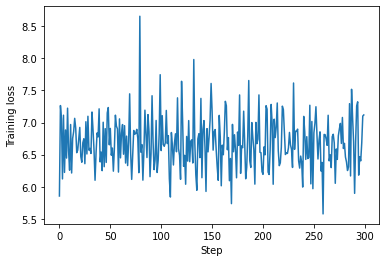

Final evaluation results
 MLGNN: 5.8305 [Best] 5.8305 [Last]


In [42]:
validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:]
yValid = yTrain[0:nValid,:]
xTrain = xTrain[nValid:,:]
yTrain = yTrain[nValid:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizer = optim.Adam(MLGNN.parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
lossValid = dict()
# ...and test variables
lossTestBest = dict()
lossTestLast = dict()

bestModel = dict()

lossTrain = []
lossValid = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:]
        yTrainBatch = yTrain[thisBatchIndices,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
       
        # Reset gradients
        MLGNN.zero_grad()

        # Obtain the output of the architectures
        yHatTrainBatch = MLGNN(xTrainBatch)

        # Compute loss
        lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

        # Compute gradients
        lossValueTrain.backward()

        # Optimize
        optimizer.step()
        
        lossTrain += [lossValueTrain.item()]
        
        # Print:
        if (epoch * nBatches + batch) % validationInterval == 0:
            with torch.no_grad():
                # Obtain the output of the GNN
                yHatValid = MLGNN(xValid)
    
            # Compute loss
            lossValueValid = loss(yHatValid, yValid)
            
            lossValid += [lossValueValid.item()]

            print("\t MLGNN: %6.4f [T]" % (
                    lossValueTrain) + " %6.4f [V]" % (
                    lossValueValid))
            
            # Saving the best model so far
            if len(lossValid) > 1:
                if lossValueValid <= min(lossValid):
                    bestModel =  copy.deepcopy(MLGNN)
            else:
                bestModel =  copy.deepcopy(MLGNN)
                    
        batch+=1
        
    epoch+=1
    
print("")

################################
############# PLOT #############
################################
 
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

with torch.no_grad():
    yHatTest = MLGNN(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" MLGNN: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))

** Multiple Feature Filters and **

In [69]:
def FilterFunction(h, S, x):
    
    # Number of output features 32
    F = h.shape[0] 
    
    # Number of filter taps
    K = h.shape[1]
    
    # Number of input features
    G = h.shape[2]
    
    # Number of nodes
    N = S.shape[1]
    
    # Batch size
    B = x.shape[0]

    # Create concatenation dimension and initialize concatenation tensor z
    x = x.reshape([B, 1, G, N])
    S = S.reshape([1, N, N])
    z = x
    
    # Loop over the number of filter taps
    for k in range(1, K):
        
        # S*x
        x = torch.matmul(x, S)
        
        # Reshape
        xS = x.reshape([B, 1, G, N])
        
        # Concatenate
        z = torch.cat((z, xS), dim=1)
    
    # Multiply by h
    y = torch.matmul(z.permute(0, 3, 1, 2).reshape([B, N, K*G]), 
                     h.reshape([F, K*G]).permute(1, 0)).permute(0, 2, 1)
    return y
    
    
class GraphFilter(nn.Module):
    def __init__(self, gso, k, f_in, f_out):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.f_in = f_in
        self.f_out = f_out
        self.weight = nn.Parameter(torch.randn(self.f_out, self.k, self.f_in))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return FilterFunction(self.weight, self.gso, x)

In [55]:
GraphFilter = torch.nn.Sequential(GraphFilter(gso=S, k=8, f_in=1, f_out=32),GraphFilter(gso=S, k=1, f_in=32, f_out=1))

In [70]:
class GNN(nn.Module):
    def __init__(self, gso, l, k, f, sigma):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.l = l
        self.k = k
        self.f = f
        self.sigma = sigma
        
        gml = []
        for layer in range(l):
            gml.append(GraphFilter(gso,k[layer],f[layer],f[layer+1]))
            gml.append(sigma)
        
        self.gml = nn.Sequential(*gml)
        
    def forward(self, x):
        return self.gml(x)


Epoch 1

    (E:  1, B:   1) 
	MFGraphFilter: 7.3431 [T] 4.9102 [V]
	GNN 1 layer  : 6.7018 [T] 4.4461 [V]
	GNN 2 layer  : 6.8002 [T] 4.4806 [V]

    (E:  1, B:   6) 
	MFGraphFilter: 5.2073 [T] 4.4465 [V]
	GNN 1 layer  : 4.9741 [T] 4.4958 [V]
	GNN 2 layer  : 4.9311 [T] 4.4690 [V]

Epoch 2

    (E:  2, B:   1) 
	MFGraphFilter: 5.1589 [T] 4.5256 [V]
	GNN 1 layer  : 5.1930 [T] 4.4528 [V]
	GNN 2 layer  : 5.1742 [T] 4.4499 [V]

    (E:  2, B:   6) 
	MFGraphFilter: 5.4888 [T] 4.4957 [V]
	GNN 1 layer  : 5.5024 [T] 4.4460 [V]
	GNN 2 layer  : 5.4871 [T] 4.4483 [V]

Epoch 3

    (E:  3, B:   1) 
	MFGraphFilter: 5.7054 [T] 4.4666 [V]
	GNN 1 layer  : 5.7132 [T] 4.4386 [V]
	GNN 2 layer  : 5.7086 [T] 4.4425 [V]

    (E:  3, B:   6) 
	MFGraphFilter: 4.9231 [T] 4.4434 [V]
	GNN 1 layer  : 4.9297 [T] 4.4356 [V]
	GNN 2 layer  : 4.9286 [T] 4.4410 [V]

Epoch 4

    (E:  4, B:   1) 
	MFGraphFilter: 4.9984 [T] 4.4349 [V]
	GNN 1 layer  : 5.0005 [T] 4.4320 [V]
	GNN 2 layer  : 5.0023 [T] 4.4360 [V]

    (E:  4,

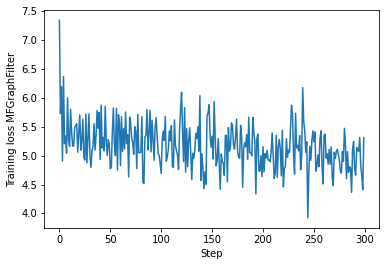

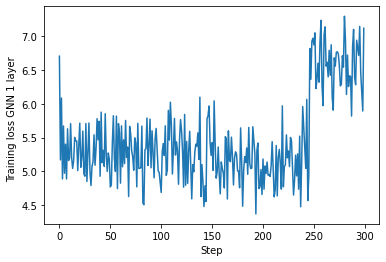

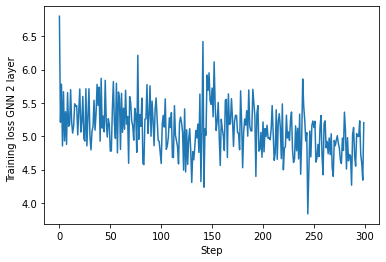

Final evaluation results
 MFGraphFilter: 5.1693 [Best] 5.1683 [Last]
 GNN 1 layer  : 5.2570 [Best] 6.9427 [Last]
 GNN 2 layer  : 5.0872 [Best] 5.0853 [Last]


In [72]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 31 10:51:49 2020

@author: Luana Ruiz
"""

"""
LAB 2: SOURCE LOCALIZATION
"""

#\\\ Standard libraries:



################################
####### DATA GENERATION ########
################################


nTrain = 2000
nTest = 100


trainData, testData = split_data(x, y, (nTrain,nTest))
xTrain = trainData[0]
yTrain = trainData[1]
xTest = testData[0]
yTest = testData[1]

xTrain = torch.tensor(xTrain)
xTrain = xTrain.reshape([-1,1,N])
yTrain = torch.tensor(yTrain)
yTrain = yTrain.reshape([-1,1,N])

xTest = torch.tensor(xTest)
xTest = xTest.reshape([-1,1,N])
yTest = torch.tensor(yTest)
yTest = yTest.reshape([-1,1,N])


################################
######## LOSS FUNCTION #########
################################

loss = nn.MSELoss()


################################
######## ARCHITECTURES #########
################################

architectures = dict()

# Multi-feature graph filter

MLgraphFilter = nn.Sequential(GraphFilter(S,8,1,32), 
                              GraphFilter(S,1,32,1))
architectures['MFGraphFilter'] = MLgraphFilter

# GNN, 1 layer

GNN1Ly = GNN(S,2,[8,1],[1,32,1],nn.ReLU())
architectures['GNN 1 layer  '] = GNN1Ly

# GNN, 2 layers

GNN2Ly = GNN(S,3,[5,5,1],[1,16,4,1],nn.ReLU())
architectures['GNN 2 layer  '] = GNN2Ly


################################
########### TRAINING ###########
################################

validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:,:]
yValid = yTrain[0:nValid,:,:]
xTrain = xTrain[nValid:,:,:]
yTrain = yTrain[nValid:,:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizers = dict()
for key in architectures.keys():
    optimizers[key] = optim.Adam(architectures[key].parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
costTrain = dict()
lossValid = dict()
costValid = dict()
# ...and test variables
lossTestBest = dict()
costTestBest = dict()
lossTestLast = dict()
costTestLast = dict()

bestModel = dict()

for key in architectures.keys():
    lossTrain[key] = []
    costTrain[key] = []
    lossValid[key] = []
    costValid[key] = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:,:]
        yTrainBatch = yTrain[thisBatchIndices,:,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
        for key in architectures.keys():
            # Reset gradients
            architectures[key].zero_grad()

            # Obtain the output of the architectures
            yHatTrainBatch = architectures[key](xTrainBatch)

            # Compute loss
            lossValueTrain = loss(yHatTrainBatch.squeeze(), yTrainBatch.squeeze())
    
            # Compute gradients
            lossValueTrain.backward()
    
            # Optimize
            optimizers[key].step()

            costValueTrain = lossValueTrain.item()
            
            lossTrain[key] += [lossValueTrain.item()]
            costTrain[key] += [costValueTrain]
            
            # Print:
            if (epoch * nBatches + batch) % validationInterval == 0:
                with torch.no_grad():
                    # Obtain the output of the GNN
                    yHatValid = architectures[key](xValid)
        
                # Compute loss
                lossValueValid = loss(yHatValid.squeeze(), yValid.squeeze())

                # Compute accuracy:
                costValueValid = lossValueValid.item()
                
                lossValid[key] += [lossValueValid.item()]
                costValid[key] += [costValueValid]

                print("\t" + key + ": %6.4f [T]" % (
                        costValueTrain) + " %6.4f [V]" % (
                        costValueValid))
                
                # Saving the best model so far
                if len(costValid[key]) > 1:
                    if costValueValid <= min(costValid[key]):
                        bestModel[key] =  copy.deepcopy(architectures[key])
                else:
                    bestModel[key] =  copy.deepcopy(architectures[key])
                    
        batch+=1
        
    epoch+=1
    
print("")
 
 
################################
############# PLOT #############
################################
 
for key in architectures.keys():
    plt.plot(lossTrain[key])
    plt.ylabel('Training loss ' + key)
    plt.xlabel('Step')
    plt.show()
  
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

for key in architectures.keys():
    with torch.no_grad():
        yHatTest = architectures[key](xTest)
    lossTestLast[key] = loss(yHatTest.squeeze(), yTest.squeeze())
    costTestLast[key] = lossTestLast[key].item()
    with torch.no_grad():
        yHatTest = bestModel[key](xTest)
    lossTestBest[key] = loss(yHatTest.squeeze(), yTest.squeeze())
    costTestBest[key] = lossTestBest[key].item()
    
    print(" " + key + ": %6.4f [Best]" % (
                        costTestBest[key]) + " %6.4f [Last]" % (
                        costTestLast[key]))
 
    
